# Statistical analysis of CTCF binding sites: orientation, chip-seq scores and motif scores

In [50]:
import src
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns

from pybedtools.bedtool import BedTool
from pybedtools import cleanup
cleanup()

figure_path = src.figures_path / "ctcf_analysis"
os.makedirs(figure_path, exist_ok=True)

In [51]:
ctcfs = pd.read_csv(src.processed_data_path / "ctcfs.tsv", sep="\t")
ctcfs.head()

,chr,start,end,orientation
0,chr1,237593,237953,>
1,chr1,521337,521697,>
2,chr1,714087,714447,>
3,chr1,805232,805362,>
4,chr1,839966,840326,>


### Counting the orientation of CTCF sites across the whole genome

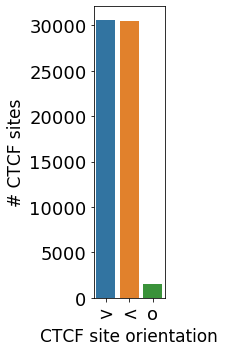

In [52]:
fig = plt.figure(figsize=(3,5))
sns.countplot(ctcfs.orientation)
plt.xlabel("CTCF site orientation")
plt.ylabel("# CTCF sites")
fig.savefig(figure_path / "CTCF_orientations_count.pdf", bbox_inches='tight', transparent=True)
plt.show()

# CTCF ChipSeq signal analysis

In [53]:
def read_narrow_peak(path):
    return pd.read_csv(path, names=['chr', 'start', 'end', 'name', 'score', 'strand', 'signalValue', 'pValue', 'qValue', 'peak'], sep="\t")

In [54]:
ctcf_files_info = pd.read_csv(src.external_data_path / "CTCF_signals" / 'info.tsv', sep="\t")
ctcf_files_info['merged_name'] = ctcf_files_info.cell + "__" + \
                                 ctcf_files_info.treatment.map(lambda x: x if (isinstance(x, str)) and (x != 'no') else '') + "__" + \
                                 ctcf_files_info.Lineage.map(lambda x: x.replace(" ", "_")) + "__" + \
                                 ctcf_files_info.Tissue.map(lambda x: x.replace(" ", "_")) + "__" + \
                                 ctcf_files_info.Karyotype.map(lambda x: x.replace(" ", "_"))
ctcf_files_info.head()

,File,treatment,cell,Tier,Description,Lineage,Tissue,Karyotype,Sex,Documents,Vendor ID,Term ID,Label,tier,merged_name
0,wgEncodeOpenChromChipH1hescCtcfPk.narrowPeak.gz,no,H1-hESC,1,embryonic stem cells,inner cell mass,embryonic stem cell,normal,M,ENCODE,WiCell Research Institute WA01,CL:0000007,H1-hESC,1.0,H1-hESC ____inner_cell_mass___embryonic_stem_c...
1,wgEncodeOpenChromChipKidneyocCtcfPkRep1.narrow...,NaN,Kidney_OC,3,Primary frozen kidney tissue from NICHD donor ...,mixed?,kidney,normal,B,Crawford,"NICHD 1104, NICHD 602, NICHD 1442, NCTC 10-002...",BTO:0000671,Kidney OC,NaN,Kidney_OC ____mixed?__kidney___normal_
2,wgEncodeOpenChromChipLungocCtcfPkRep1.narrowPe...,NaN,Lung_OC,3,Primary frozen lung tissue from NICHD donor ID...,mixed?,Lung,normal,B,Crawford,"NICHD 1104, NICHD 602, NICHD 1442 , CF Center ...",BTO:0000763,Lung_OC,NaN,Lung_OC ____mixed?__Lung___normal_
3,wgEncodeOpenChromChipPancreasocCtcfPkRep1.narr...,NaN,Pancreas_OC,3,Primary frozen pancreas tissue from NCTC donor...,mixed?,pancreas,normal,M,Crawford,"NCTC 09-0144A, NCTC 10-0021A",BTO:0000988,Pancreas OC,NaN,Pancreas_OC ____mixed?__pancreas___normal_
4,wgEncodeOpenChromChipFibroblCtcfPkRep1.narrowP...,NaN,Fibrobl,3,child fibroblast,mixed?,skin,normal,F,Crawford,Coriell AG08470,BTO:0000452,Fibrobl,NaN,Fibrobl ____mixed?__skin___normal_


### loading all Chip-Seq datasets

In [55]:
all_chipseq = []

for ctcf_file in src.progress(ctcf_files_info.File):
    data = read_narrow_peak(src.external_data_path / "CTCF_signals" / ctcf_file)
    info = ctcf_files_info[ctcf_files_info.File == ctcf_file].iloc[0].to_dict()
    for k,v in info.items():
        data[k] = v
    all_chipseq.append(data)
all_chipseq = pd.concat(all_chipseq, axis=0)
all_chipseq.head()

,chr,start,end,name,score,strand,signalValue,pValue,qValue,peak,...,Lineage,Tissue,Karyotype,Sex,Documents,Vendor ID,Term ID,Label,tier,merged_name
0,chr1,91385,91500,chr1.1,570,.,0.2714,2.40,-1,71,...,inner cell mass,embryonic stem cell,normal,M,ENCODE,WiCell Research Institute WA01,CL:0000007,H1-hESC,1.0,H1-hESC ____inner_cell_mass___embryonic_stem_c...
1,chr1,237721,237820,chr1.2,547,.,0.2062,1.99,-1,39,...,inner cell mass,embryonic stem cell,normal,M,ENCODE,WiCell Research Institute WA01,CL:0000007,H1-hESC,1.0,H1-hESC ____inner_cell_mass___embryonic_stem_c...
2,chr1,521512,521597,chr1.3,534,.,0.1707,1.75,-1,49,...,inner cell mass,embryonic stem cell,normal,M,ENCODE,WiCell Research Institute WA01,CL:0000007,H1-hESC,1.0,H1-hESC ____inner_cell_mass___embryonic_stem_c...
3,chr1,545005,545041,chr1.4,520,.,0.1312,1.49,-1,13,...,inner cell mass,embryonic stem cell,normal,M,ENCODE,WiCell Research Institute WA01,CL:0000007,H1-hESC,1.0,H1-hESC ____inner_cell_mass___embryonic_stem_c...
4,chr1,546015,546153,chr1.5,590,.,0.3269,2.74,-1,89,...,inner cell mass,embryonic stem cell,normal,M,ENCODE,WiCell Research Institute WA01,CL:0000007,H1-hESC,1.0,H1-hESC ____inner_cell_mass___embryonic_stem_c...


### SignalValue distribution across all datasets

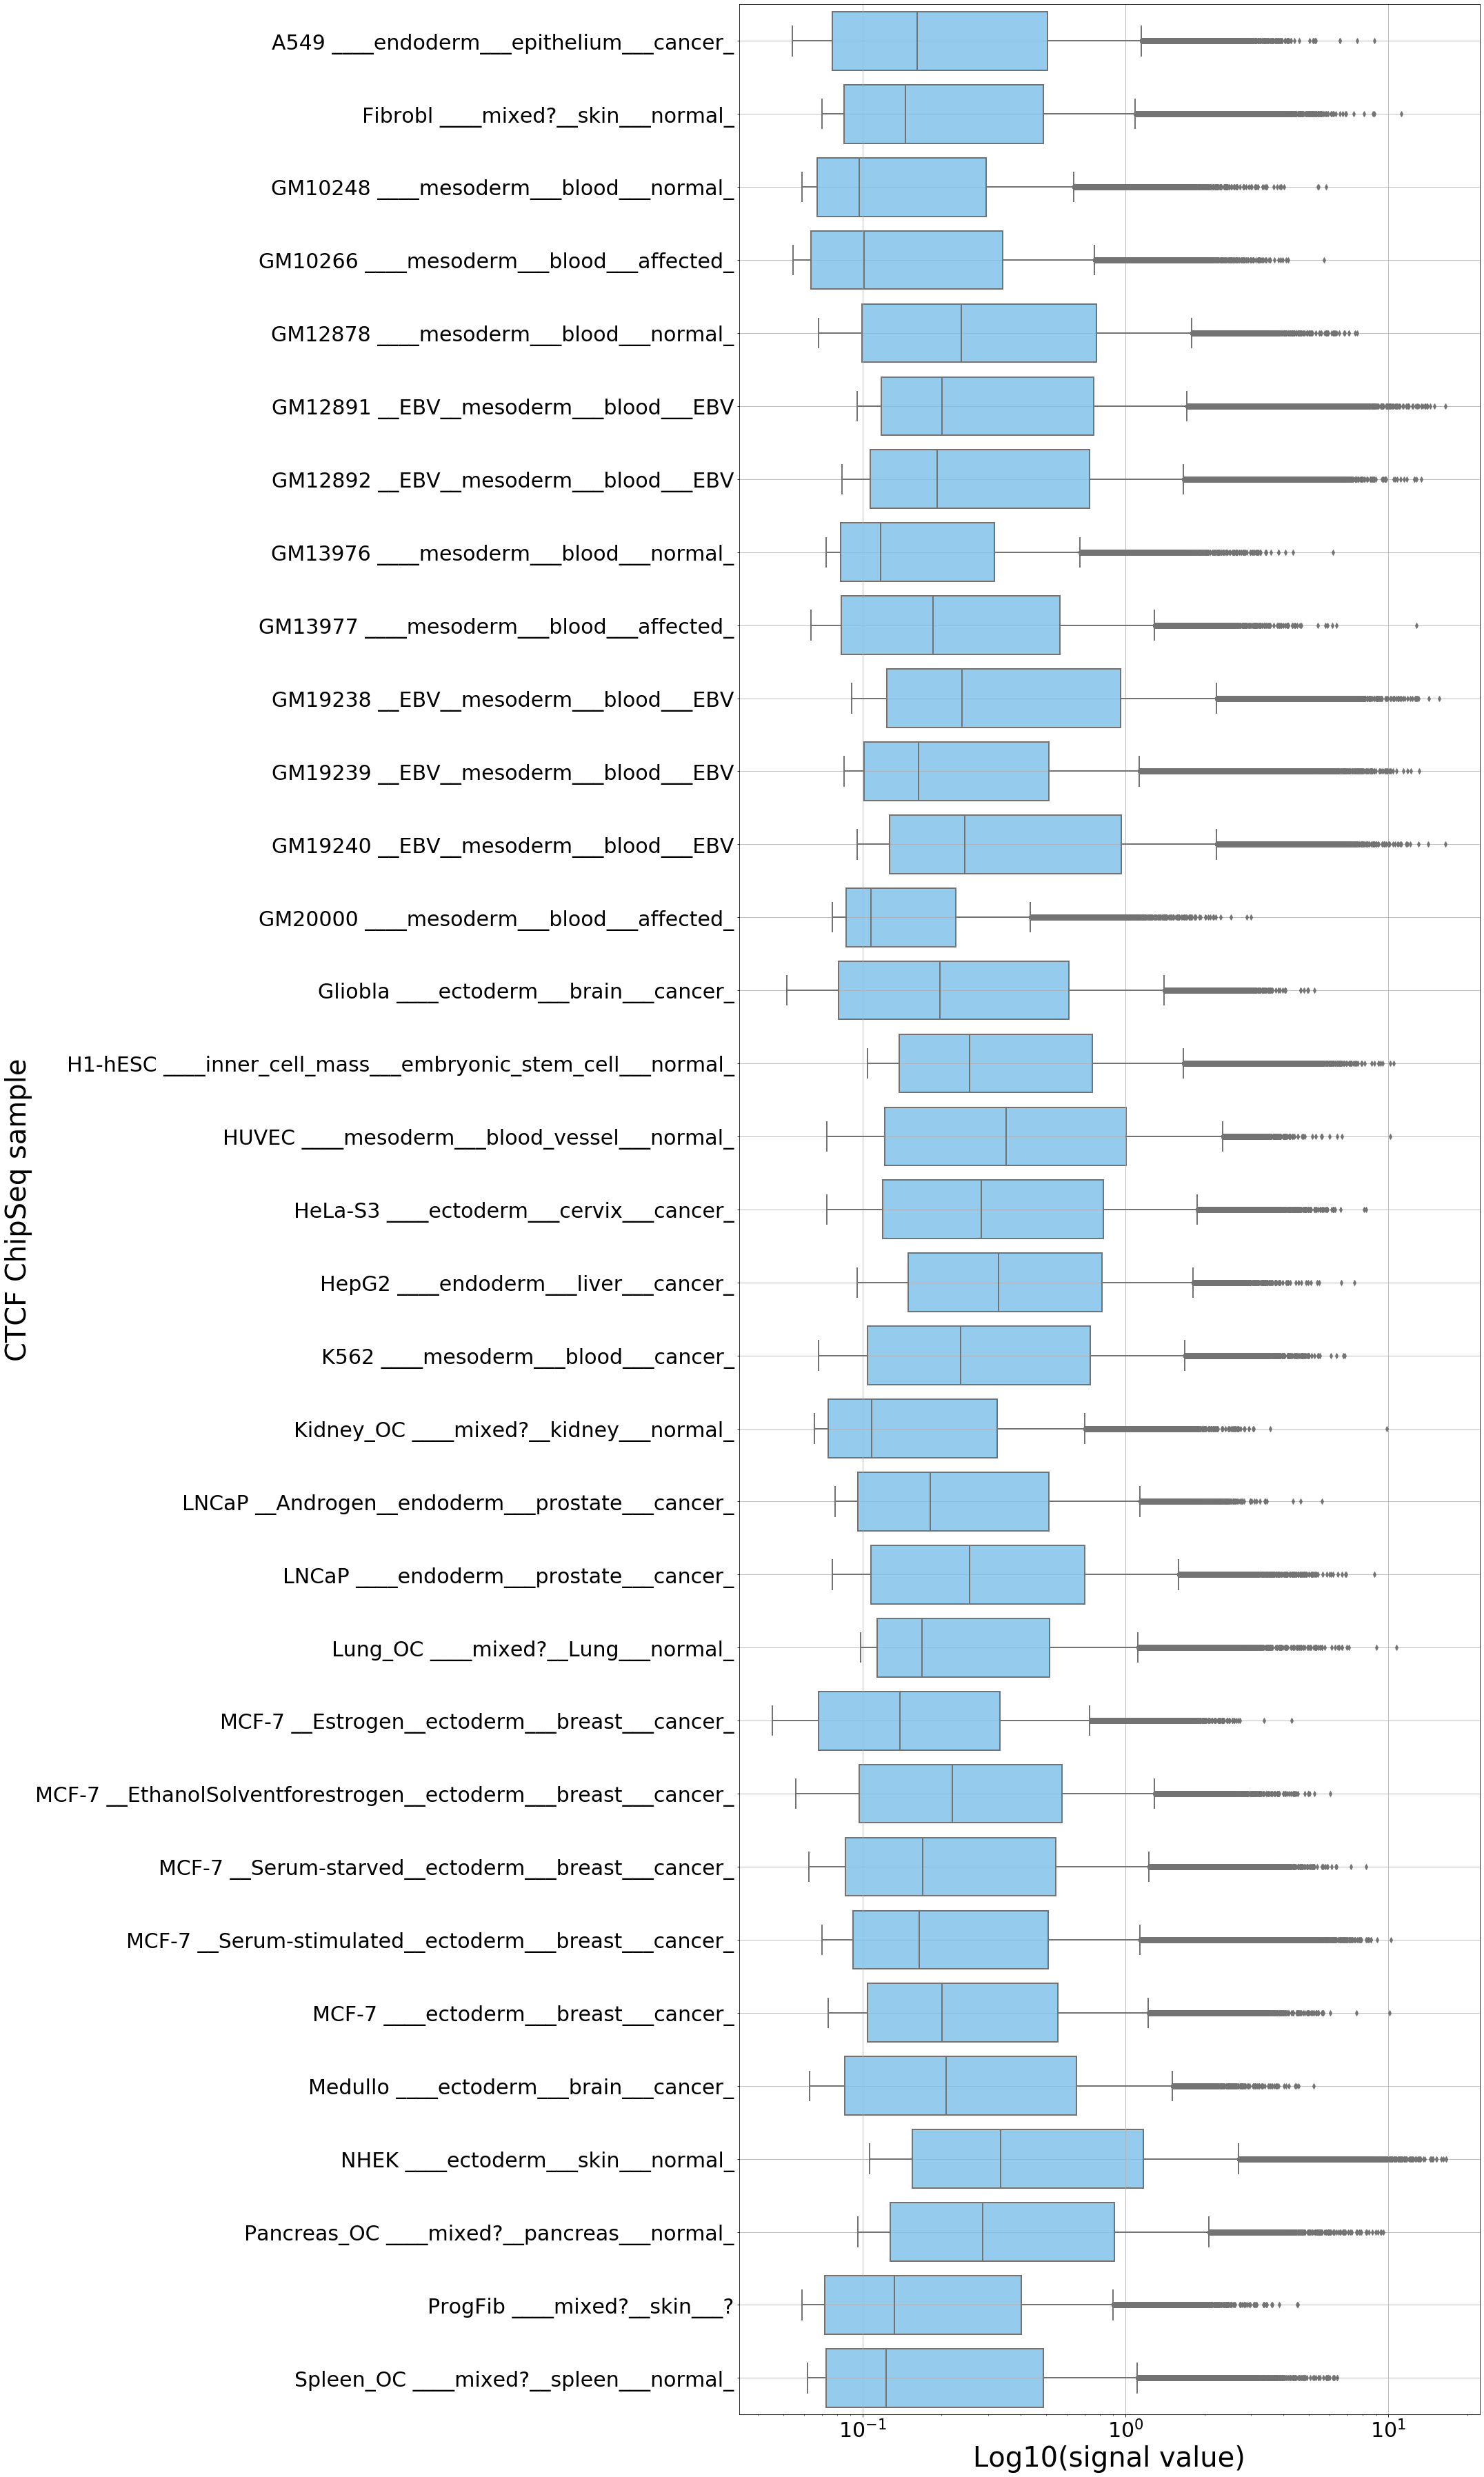

In [56]:
fig = plt.figure(figsize=(30, 50))
order = ctcf_files_info.merged_name.sort_values().values
sns.boxplot(data=all_chipseq, y="merged_name", x="signalValue", color='lightskyblue', order=order)
plt.xscale('log')
plt.yticks(fontsize=30, rotation=0)
plt.ylabel("CTCF ChipSeq sample", fontsize=40)
plt.xlabel("Log10(signal value)", fontsize=40)
plt.xticks(fontsize=30)
# plt.legend(bbox_to_anchor=(1.1, 1))
plt.grid()
fig.savefig(figure_path / "CTCF_chipseq_signals_distributions.pdf", bbox_inches='tight', transparent=True)
plt.show()

## Mapping signals to CTCF sites

In [57]:
def map_signal_on_sites(ctcf_sites, sample, name, slop=0):
    ctcf_bed = BedTool.from_dataframe(ctcf_sites)
    if slop > 0:
        ctcf_bed = ctcf_bed.slop(b=slop, genome='hg19')
    ctcf_on_sample = ctcf_bed.map(BedTool.from_dataframe(sample).sort(), c=4, o='max')\
                             .to_dataframe(names=ctcf_sites.columns.tolist() + [name])
    ctcf_on_sample[name] = ctcf_on_sample[name].map(lambda y: float(y) if y != '.' else 0)
    return ctcf_on_sample

In [58]:
slop = 0
ctcf_mappings = ctcfs.copy()

for sn, sample in src.progress(all_chipseq.groupby("merged_name")):
    sample = sample.sort_values(src.coords)[src.coords + ['signalValue']]
    ctcf_on_sample = map_signal_on_sites(ctcfs, sample, sn, slop)
    ctcf_mappings[sn] = ctcf_on_sample[sn]

In [59]:
sample_names = ctcf_mappings.columns[4:].tolist()
print(sample_names)

['A549 ____endoderm___epithelium___cancer_', 'Fibrobl ____mixed?__skin___normal_', 'GM10248 ____mesoderm___blood___normal_', 'GM10266 ____mesoderm___blood___affected_', 'GM12878 ____mesoderm___blood___normal_', 'GM12891 __EBV__mesoderm___blood___EBV', 'GM12892 __EBV__mesoderm___blood___EBV', 'GM13976 ____mesoderm___blood___normal_', 'GM13977 ____mesoderm___blood___affected_', 'GM19238 __EBV__mesoderm___blood___EBV', 'GM19239 __EBV__mesoderm___blood___EBV', 'GM19240 __EBV__mesoderm___blood___EBV', 'GM20000 ____mesoderm___blood___affected_', 'Gliobla ____ectoderm___brain___cancer_', 'H1-hESC ____inner_cell_mass___embryonic_stem_cell___normal_', 'HUVEC ____mesoderm___blood_vessel___normal_', 'HeLa-S3 ____ectoderm___cervix___cancer_', 'HepG2 ____endoderm___liver___cancer_', 'K562 ____mesoderm___blood___cancer_', 'Kidney_OC ____mixed?__kidney___normal_', 'LNCaP __Androgen__endoderm___prostate___cancer_', 'LNCaP ____endoderm___prostate___cancer_', 'Lung_OC ____mixed?__Lung___normal_', 'MCF-7

### Count number of overlapping ChipSeq samples for every CTCF site

In [60]:
n_overlaps = np.count_nonzero(ctcf_mappings[sample_names].values, axis=1)

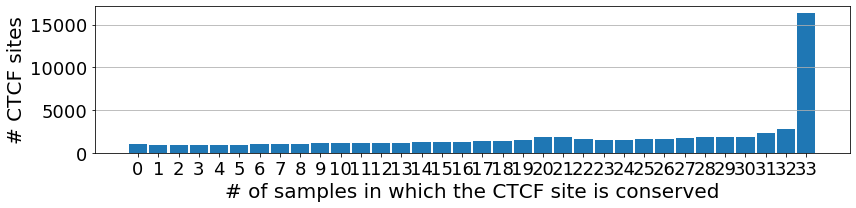

In [61]:
fig = plt.figure(figsize=(12, 3))
plt.hist(n_overlaps, bins=np.arange(max(n_overlaps) + 2), rwidth=0.9)
plt.grid(axis="y")
plt.xlabel("# of samples in which the CTCF site is conserved", fontsize=(20))
plt.ylabel("# CTCF sites", fontsize=(20))
plt.xticks(np.arange(max(n_overlaps) + 1) + 0.5, labels=np.arange(max(n_overlaps) + 1))
fig.savefig(figure_path / "CTCF_sites_number_overlaps_with_chipseqs.pdf", bbox_inches='tight', transparent=True)
plt.show()

## Quantile Normalization of the signals

In [62]:
def quantile_normalization(m):
    sort_idx = np.argsort(m, axis=0)
    ranks = np.argsort(sort_idx, axis=0)
    sorted_cols = np.sort(m, axis=0)
    col_ranks = sorted_cols.mean(1)
    qnorm = col_ranks[ranks]
    return qnorm

In [63]:
ctcf_mappings_qnorm = pd.concat([ctcf_mappings.iloc[:, :4], 
                                 pd.DataFrame(index=ctcf_mappings.index, 
                                              columns=sample_names, 
                                              data=quantile_normalization(ctcf_mappings[sample_names].values))], 
                                axis=1)

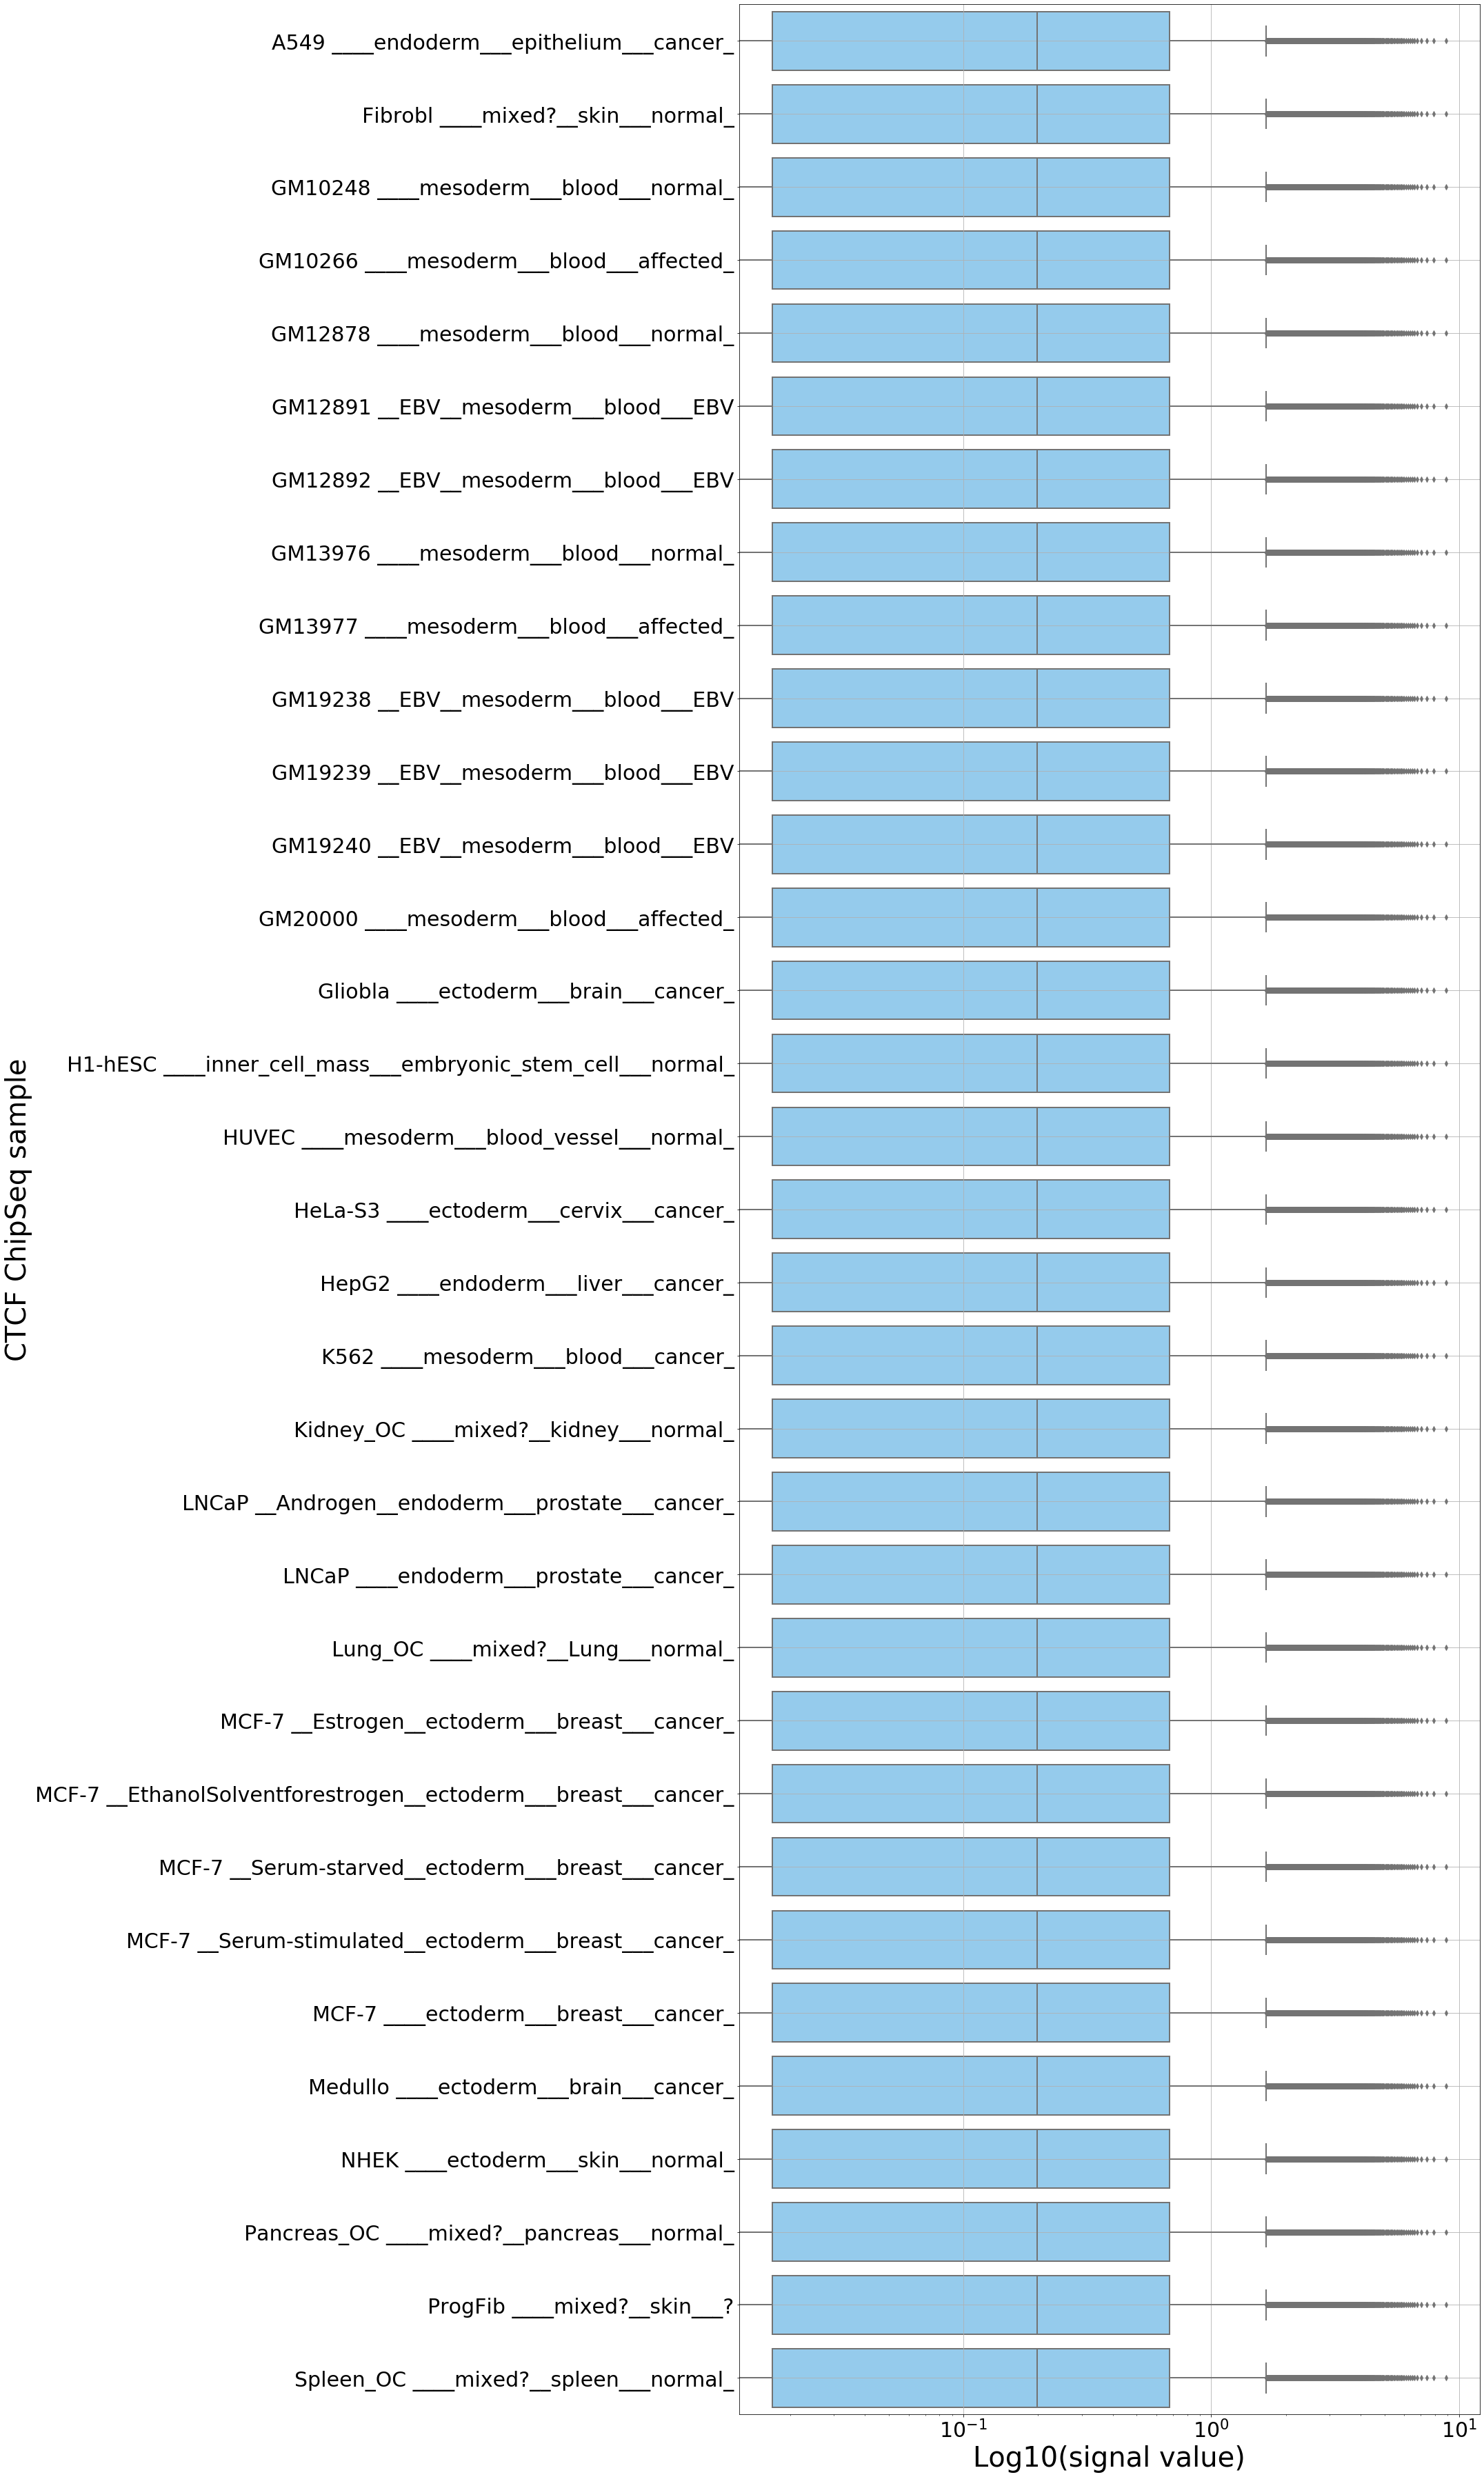

In [64]:
fig = plt.figure(figsize=(30, 50))
sns.boxplot(data=pd.melt(ctcf_mappings_qnorm[sample_names], var_name="merged_name", value_name="signalValue"), 
            y="merged_name", x="signalValue", color='lightskyblue', order=sorted(sample_names))
plt.xscale('log')
plt.yticks(fontsize=30, rotation=0)
plt.ylabel("CTCF ChipSeq sample", fontsize=40)
plt.xlabel("Log10(signal value)", fontsize=40)
plt.xticks(fontsize=30)
# plt.legend(bbox_to_anchor=(1.1, 1))
plt.grid()
fig.savefig(figure_path / "CTCF_sites_chipseq_signals_distributions_QNORM.pdf", bbox_inches='tight', transparent=True)
plt.show()

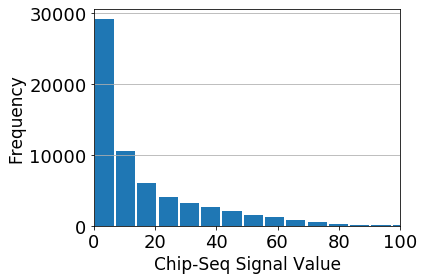

In [65]:
fig = plt.figure()
plt.hist(ctcf_mappings_qnorm[sample_names].sum(1).values, bins=30, rwidth=0.9)
plt.xlim(0,100)
plt.grid(axis='y')
plt.xlabel("Chip-Seq Signal Value")
plt.ylabel('Frequency')
fig.savefig(figure_path / "CTCF_sites_chipseq_signalvalue_sum_distribution.pdf", bbox_inches='tight', transparent=True)
plt.show()

## Assigning motif strength to CTCF binding sites

In [66]:
ctcf_motifs_strengths = pd.read_csv(src.interim_data_path / "GM12878_Aiden_peaks_with_motifscore.txt", sep="\t")
ctcf_motifs_strengths.head()

,PositionID,Offset,Sequence,Motif Name,Strand,MotifScore
0,62579,-59,TAGCTGCCAGCAGGCGGCG,CTCF_JASPAR,+,0.102811
1,62579,-56,CTGCCAGCAGGCGGCGTGC,CTCF_JASPAR,+,7.603147
2,62579,3,GCGCCACGAGGGGGCGGTG,CTCF_JASPAR,+,12.194194
3,62579,61,TCGCCAGCAGGGGGCGCCC,CTCF_JASPAR,+,15.593319
4,62579,19,CGGCGCCACGAGGGGGCGG,CTCF_JASPAR,-,0.787811


In [67]:
ctcfs_with_motif_strength = ctcfs.assign(ctcf_id=lambda x: np.arange(ctcfs.shape[0], dtype=int))\
      .merge(ctcf_motifs_strengths.groupby("PositionID")['MotifScore'].max().to_frame(), 
             left_on="ctcf_id", right_index=True, how='left').fillna(0).sort_values("ctcf_id")

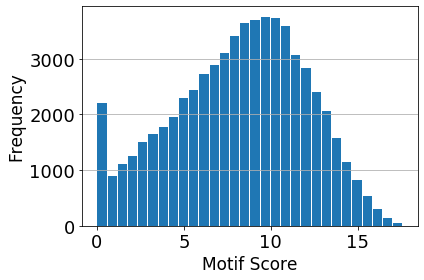

In [68]:
fig = plt.figure()
plt.hist(ctcfs_with_motif_strength.MotifScore.values, bins=30, rwidth=0.9)
# plt.xlim(0,100)
plt.grid(axis='y')
plt.xlabel("Motif Score")
plt.ylabel('Frequency')
fig.savefig(figure_path / "CTCF_sites_motif_score_distribution.pdf", bbox_inches='tight', transparent=True)
plt.show()

## Building an aggregated score

In [69]:
ctcfs_ms_cs = ctcfs_with_motif_strength.copy()
ctcfs_ms_cs['ChipSeqScore'] = ctcf_mappings_qnorm[sample_names].sum(1).values
ctcfs_ms_cs.head()

,chr,start,end,orientation,ctcf_id,MotifScore,ChipSeqScore
0,chr1,237593,237953,>,0,9.790746,12.639115
1,chr1,521337,521697,>,1,10.259412,13.836791
2,chr1,714087,714447,>,2,9.893988,9.326291
3,chr1,805232,805362,>,3,14.365820,46.641218
4,chr1,839966,840326,>,4,16.393501,60.468042


In [70]:
ctcfs_ms_cs['rank_score_aggregate'] = ctcfs_ms_cs.ChipSeqScore.rank() * ctcfs_ms_cs.MotifScore.rank()
ctcfs_ms_cs.head()

,chr,start,end,orientation,ctcf_id,MotifScore,ChipSeqScore,rank_score_aggregate
0,chr1,237593,237953,>,0,9.790746,12.639115,1.502743e+09
1,chr1,521337,521697,>,1,10.259412,13.836791,1.680162e+09
2,chr1,714087,714447,>,2,9.893988,9.326291,1.342770e+09
3,chr1,805232,805362,>,3,14.365820,46.641218,3.446545e+09
4,chr1,839966,840326,>,4,16.393501,60.468042,3.756117e+09


In [72]:
ctcfs_ms_cs[src.coords + ['rank_score_aggregate']].to_csv(src.interim_data_path / "GM12878_ctcfs_rankscore.bed", sep='\t', index=False, header=False)
ctcfs_ms_cs[src.coords + ['MotifScore']].to_csv(src.interim_data_path / "GM12878_ctcfs_motifcore.bed", sep='\t', index=False, header=False)
ctcfs_ms_cs[src.coords + ['ChipSeqScore']].to_csv(src.interim_data_path / "GM12878_ctcfs_chipseqcore.bed", sep='\t', index=False, header=False)

In [73]:
ctcfs_ms_cs.to_csv(src.interim_data_path / "ctcf_scores.tsv", sep='\t', index=False, header=True)

In [74]:
quantiles = np.quantile(ctcfs_ms_cs.rank_score_aggregate, q=[0.25, 0.50, 0.75])
quantiles

array([2.30788054e+08, 8.36041215e+08, 1.88969308e+09])

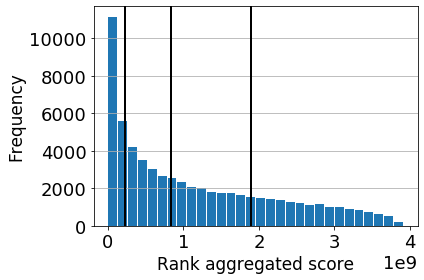

In [75]:
fig = plt.figure()
plt.hist(ctcfs_ms_cs['rank_score_aggregate'], bins=30, rwidth=0.9)
[plt.axvline(q, color='black') for q in quantiles]
# plt.xlim(0,100)
plt.grid(axis='y')
plt.xlabel("Rank aggregated score")
plt.ylabel('Frequency')
fig.savefig(figure_path / "CTCF_sites_rank_aggregated_score_distribution.pdf", bbox_inches='tight', transparent=True)
plt.show()